# Electron-Photon Classification with Classical GNN Sage Network

In this notebook, we try to use image dataset with GNNs. Specifically, we use the Electron Photon dataset (32x32 in size). The images are sparse and so we can convert them into graphs. We use a SAGE network to train on subset of the data (100k train data).

In [21]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch_geometric.data as geom_data
import torch
import torch.nn as nn
from torch_geometric.nn import knn_graph, radius_graph
import torch_geometric.loader as geom_loader
import torch_geometric.transforms as geom_transforms
import torch.optim as optim
import torch_geometric.nn as geom_nn
import pytorch_lightning as pl
import os
import networkx as nx
import torch_geometric as geom
from torchmetrics import AUROC
import warnings
import pandas as pd

warnings.filterwarnings(
    "ignore", ".*TypedStorage is deprecated*"
)
torch.set_float32_matmul_precision("high")

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
class EPDataset(geom_data.Dataset):
    def __init__(self, root, filename, stop = None, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(EPDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
    
        data = np.load('../data/ep/raw/electron_photon_2.npz', allow_pickle = True)

        if self.test:
            self.n_graphs = 19970
            return [f'data_test_{i}.pt' for i in range(self.n_graphs)]
        else:
            self.n_graphs = 99890
            return [f'data_{i}.pt' for i in range(self.n_graphs)]

    def download(self):
        pass

    def process(self):
    
        data = np.load('../data/ep/raw/electron_photon_2.npz', allow_pickle = True)
        
        if self.test:
            x = data['x_test']
            y = data['y_test']
        else:
            x = data['x_train']
            y = data['y_train']
        
        self.n_graphs = x.shape[0]
        
        graph_counter = 0
        for idx in tqdm(range(self.n_graphs)):
            image = x[idx]
            label = torch.tensor([int(y[idx])], dtype=torch.int64)
            image = image.reshape(32,32)
            image = torch.tensor(image)
            
            x_hit,y_hit = torch.nonzero(image,as_tuple=True)  # Select hits in detector
            energy = image[x_hit, y_hit]*50
            
            # concatenate x,y locations and energies (3 features in total)
            node_feats = torch.stack((x_hit.float(),y_hit.float(),energy),dim=1) 
            coords = node_feats[:,[0,1]] # cords = x,y coordinates 
            
            if len(coords) == 0:
                continue
                
            # Create knn graph adjacency matrix
            edge_index = knn_graph(coords, k=4, batch=None, loop=True, num_workers=12) 
            
            # Create data object
            data = geom_data.Data(x=node_feats, 
                        edge_index=edge_index,
                        pos = coords,
                        y=label)
            
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{graph_counter}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{graph_counter}.pt'))
            graph_counter += 1
        
        self.n_graphs = graph_counter

    def len(self):
        return self.n_graphs

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [4]:
train_dataset = EPDataset(root = '../data/ep/', filename='electron_photon_2.npz')
test_dataset = EPDataset(root = '../data/ep/', filename='electron_photon_2.npz', test = True)

In [5]:
train_dataset, test_dataset

(EPDataset(99890), EPDataset(19970))

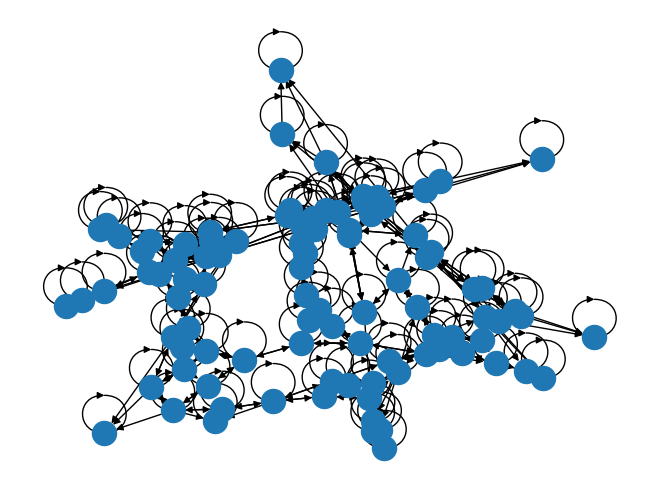

In [6]:
nx.draw(geom.utils.to_networkx(train_dataset[0]))

In [7]:
train_dataset[1]

Data(x=[40, 3], edge_index=[2, 160], y=[1], pos=[40, 2])

In [8]:
batch_size = 128
train_dataloader = geom_loader.DataLoader(train_dataset, 
                                          batch_size = batch_size,
                                          num_workers = 12,
                                          drop_last = True,
                                          shuffle=True)
val_dataloader = geom_loader.DataLoader(test_dataset, 
                                        batch_size = batch_size, 
                                        num_workers = 12,
                                        drop_last = True,
                                        shuffle=False)

In [9]:
for batch in tqdm(train_dataloader):
    assert batch_size == torch.unique(batch.batch).shape[0]

100%|████████████████████████████████████████| 780/780 [00:06<00:00, 113.74it/s]


In [10]:
from lit_model import GraphLevelGNN

In [11]:
logger = pl.loggers.CSVLogger(save_dir='csv_logs',version='ep_gsage')
checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=5,
        save_weights_only=True,
        mode="max",
        monitor="val_auc"
    )
summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback, checkpoint_callback]

In [32]:
trainer = pl.Trainer(callbacks=callbacks,
                     accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                     devices=1,
                     enable_model_summary=False,
                     logger = logger,
                     max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
model_sage = GraphLevelGNN(c_in = train_dataset.num_node_features,
                          c_hidden =16,
                          c_out=1,
                          batch_size = batch_size)

In [34]:
trainer.fit(model_sage, train_dataloader, val_dataloader)

/home/gopald/Documents/QMLHEP-Tasks-2023/qmlhep/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory csv_logs/lightning_logs/ep_gsage/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type              | Params
-------------------------------------------------------------------------
0  | model                             | GraphGNNModel     | 5.9 K 
1  | model.sages                       | ModuleList        | 5.9 K 
2  | model.sages.0                     | GraphSAGE         | 1.7 K 
3  | model.sages.0.act                 | ReLU              | 0     
4  | model.sages.0.convs               | ModuleList        | 1.7 K 
5  | model.sages.0.convs.0             | SAGEConv          | 112   
6  | model.sages.0.convs.0.aggr_module | MeanAggregation   | 0     
7  | model.sages.0.convs.0.li

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
val_result = trainer.test(model_sage, val_dataloader, verbose=False)
val_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_auc': 0.7187669277191162}]

In [46]:
df = pd.read_csv('csv_logs/lightning_logs/ep_gsage/metrics.csv')
df_grp = df.groupby('epoch').mean()

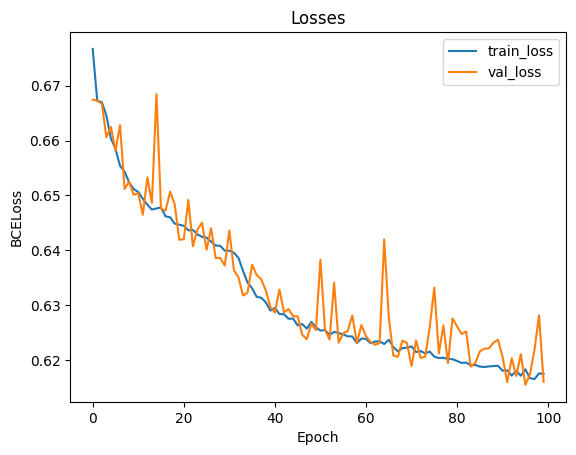

In [47]:
plt.plot(df_grp.index, df_grp['train_loss'])
plt.plot(df_grp.index, df_grp['val_loss'])
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

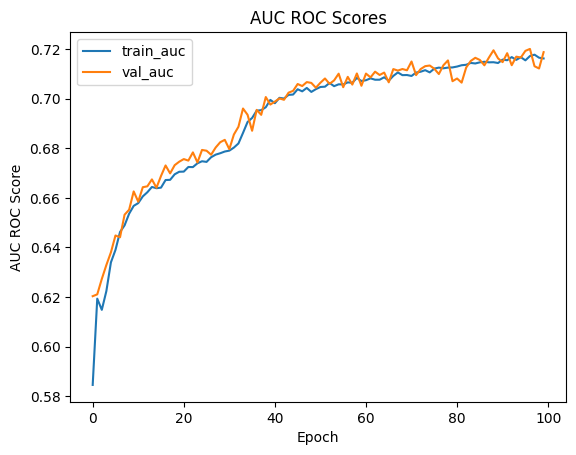

In [48]:
plt.plot(df_grp.index, df_grp['train_auc'])
plt.plot(df_grp.index, df_grp['val_auc'])
plt.title('AUC ROC Scores')
plt.xlabel('Epoch')
plt.ylabel('AUC ROC Score')
plt.legend(['train_auc', 'val_auc'])
plt.show()

## Conclusion

We created graph representation of Electron Photon dataset using KNN algorithm. We were able to train the SAGE model and achieved test AUC of 0.71. More data and fine tuning of the mode is needed to achieve satisfactory results.